<a href="https://colab.research.google.com/github/DavidDau/Kira_Health_Assistant/blob/main/medical_chatbot_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Q&A Chatbot — LLM Fine-Tuning with LoRA
**Domain:** Healthcare  
**Base Model:** TinyLlama-1.1B-Chat  
**Dataset:** medalpaca/medical_meadow_medical_flashcards  
**Technique:** Parameter-Efficient Fine-Tuning (LoRA via PEFT)  
**Interface:** Gradio  

---
**Run this notebook end-to-end on Google Colab (free T4 GPU).**  
Estimated total runtime: ~45–60 minutes on T4.

## Cell 1 — Install Dependencies

In [ ]:
# Fix numpy/pandas compatibility explicitly
!pip install -q --upgrade pip

# Stable, compatible versions for Colab Python 3.12
!pip install -q numpy==1.26.4
!pip install -q pandas==2.2.2

# Core libraries
# 🔥 Completely remove broken transformers installation
!pip uninstall -y transformers

# Remove any leftover corrupted folders
!rm -rf /usr/local/lib/python3.12/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.12/dist-packages/~ransformers*

# Reinstall clean version
!pip install -q transformers==4.41.2
!pip install -q peft==0.10.0
!pip install -q datasets==2.19.0
!pip install -q trl==0.8.6
!pip install -q accelerate==0.29.3
!pip install -q bitsandbytes==0.43.1
!pip install -q evaluate==0.4.1
!pip install -q rouge_score==0.1.2
!pip install -q sacrebleu==2.3.1
!pip install -q gradio==4.31.0
!pip install -q matplotlib==3.8.4
!pip install -q seaborn==0.13.2

print("✅ All packages installed successfully!")

Found existing installation: transformers 4.40.0
Uninstalling transformers-4.40.0:
  Successfully uninstalled transformers-4.40.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.3 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.
✅ All packages installed successfully!


## Cell 2 — Import Libraries

In [ ]:
import os
import json
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Optional

import torch
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    TrainerCallback,
    BitsAndBytesConfig,
    pipeline,
    set_seed,
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
    prepare_model_for_kbit_training,
)
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
import evaluate

warnings.filterwarnings("ignore")
set_seed(42)

# GPU check
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if device == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
   GPU: Tesla T4
   VRAM: 15.6 GB


## Cell 3 — Load & Explore the Dataset
Using `medalpaca/medical_meadow_medical_flashcards` from Hugging Face.
Each example has an `input` (question/prompt) and `output` (answer).

Loading dataset...


Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})

Sample examples:

--- Example 1 ---
INPUT:  What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
OUTPUT: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.

--- Example 2 ---
INPUT:  What leads to genitourinary syndrome of menopause (atrophic vaginitis)?
OUTPUT: Low estradiol production leads to genitourinary syndrome of menopause (atrophic vaginitis).

--- Example 3 ---
INPUT:  What does low REM sleep latency and experiencing hallucinations/sleep paralysis suggest?
OUTPUT: Low REM sleep latency and experiencing hallucinations/sleep paralysis suggests narcolepsy.

Dataset Statistics:
   Total examples : 33,955
   Avg input length  : 14.6 words
   Avg output length : 53.5 words
   Max input length  : 62 words
   Max output length : 245 words


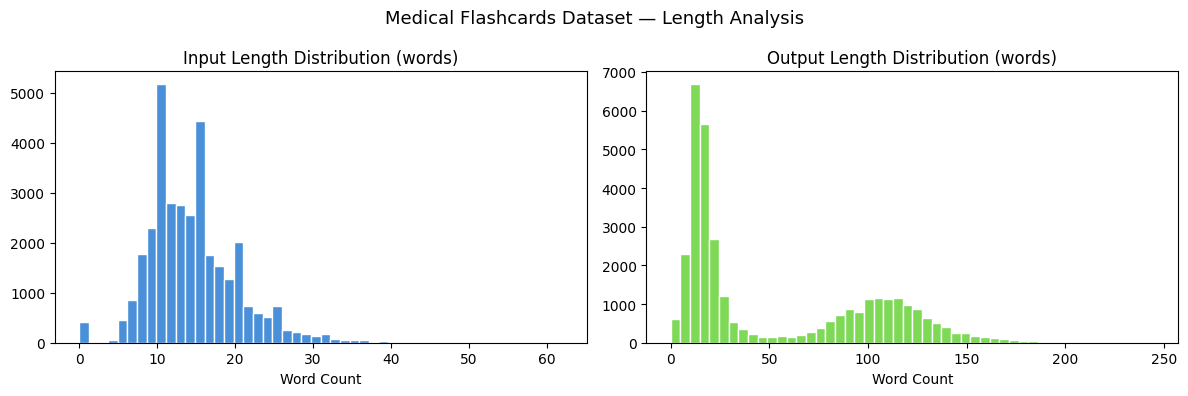

Dataset loaded and analyzed.


In [ ]:
print("Loading dataset...")
raw_dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
print(raw_dataset)

# Inspect a few samples
print("\nSample examples:")
for i in range(3):
    sample = raw_dataset["train"][i]
    print(f"\n--- Example {i+1} ---")
    print(f"INPUT:  {sample['input'][:200]}")
    print(f"OUTPUT: {sample['output'][:200]}")

# Dataset statistics
train_data = raw_dataset["train"]
input_lengths = [len(ex["input"].split()) for ex in train_data]
output_lengths = [len(ex["output"].split()) for ex in train_data]

print(f"\nDataset Statistics:")
print(f"   Total examples : {len(train_data):,}")
print(f"   Avg input length  : {np.mean(input_lengths):.1f} words")
print(f"   Avg output length : {np.mean(output_lengths):.1f} words")
print(f"   Max input length  : {max(input_lengths)} words")
print(f"   Max output length : {max(output_lengths)} words")

# Quick distribution plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(input_lengths, bins=50, color="#4A90D9", edgecolor="white")
axes[0].set_title("Input Length Distribution (words)")
axes[0].set_xlabel("Word Count")
axes[1].hist(output_lengths, bins=50, color="#7ED956", edgecolor="white")
axes[1].set_title("Output Length Distribution (words)")
axes[1].set_xlabel("Word Count")
plt.suptitle("Medical Flashcards Dataset — Length Analysis", fontsize=13)
plt.tight_layout()
plt.savefig("dataset_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print("Dataset loaded and analyzed.")

## Cell 4 — Data Preprocessing
Steps:
1. **Filter** — remove examples that are too short or too long.
2. **Format** — wrap each example in an instruction-response template.
3. **Split** — 90% train / 10% validation.
4. **Tokenize** — verify sequences fit within context window (2048 tokens).

In [ ]:
# ── Configuration ──────────────────────────────────────────────────────────────
MODEL_NAME    = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MAX_SEQ_LEN   = 512     # context window for training
MIN_INPUT_LEN = 10      # minimum characters for input
MAX_INPUT_LEN = 800     # maximum characters for input
MAX_OUTPUT_LEN = 600    # maximum characters for output
DATASET_SIZE  = 2000    # cap training examples (adjust if GPU is tight)
# ───────────────────────────────────────────────────────────────────────────────

# ── Step 1: Filter noisy / oversized examples ──────────────────────────────────
def is_valid(example):
    inp = example["input"].strip()
    out = example["output"].strip()
    return (
        len(inp) >= MIN_INPUT_LEN
        and len(inp) <= MAX_INPUT_LEN
        and len(out) >= 5
        and len(out) <= MAX_OUTPUT_LEN
        and inp != out          # skip duplicates
    )

filtered = train_data.filter(is_valid)
print(f"After filtering: {len(filtered):,} examples  (removed {len(train_data) - len(filtered):,})")

# ── Step 2: Subsample + train/validation split ─────────────────────────────────
if len(filtered) > DATASET_SIZE:
    filtered = filtered.shuffle(seed=42).select(range(DATASET_SIZE))

split = filtered.train_test_split(test_size=0.10, seed=42)
train_split = split["train"]
val_split   = split["test"]
print(f"Train : {len(train_split):,}  |  Validation : {len(val_split):,}")

# ── Step 3: Instruction-Response Template ──────────────────────────────────────
# TinyLlama uses ChatML format.  We wrap every example in the chat template.
SYSTEM_PROMPT = (
    "You are a knowledgeable and concise medical assistant. "
    "Answer the medical question accurately based on established clinical knowledge. "
    "If you are unsure, state that clearly rather than guessing."
)

def format_example(example):
    """
    Format a single example into TinyLlama ChatML instruction template.
    Returns a dict with a single key 'text' containing the full prompt string.
    """
    question = example["input"].strip()
    answer   = example["output"].strip()

    text = (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{question}</s>\n"
        f"<|assistant|>\n{answer}</s>"
    )
    return {"text": text}

train_formatted = train_split.map(format_example, remove_columns=train_split.column_names)
val_formatted   = val_split.map(format_example,   remove_columns=val_split.column_names)

# ── Step 4: Verify tokenization lengths ────────────────────────────────────────
print("\nLoading tokenizer to verify sequence lengths...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"   # required for SFTTrainer

# Sample 500 examples to check token lengths
sample_texts = [train_formatted[i]["text"] for i in range(min(500, len(train_formatted)))]
token_lengths = [len(tokenizer(t)["input_ids"]) for t in sample_texts]

print(f"\nToken Length Statistics (sample of 500):")
print(f"   Mean   : {np.mean(token_lengths):.1f}")
print(f"   Median : {np.median(token_lengths):.1f}")
print(f"   95th % : {np.percentile(token_lengths, 95):.1f}")
print(f"   Max    : {max(token_lengths)}")
pct_over = sum(1 for l in token_lengths if l > MAX_SEQ_LEN) / len(token_lengths) * 100
print(f"   > {MAX_SEQ_LEN} tokens : {pct_over:.1f}%  (will be truncated)")

# Show 3 formatted examples
print("\nSample formatted prompts:")
for i in range(2):
    print(f"\n{'='*60}")
    print(train_formatted[i]["text"][:600])
    print("...")

print("\nPreprocessing complete.")

Filter:   0%|          | 0/33955 [00:00<?, ? examples/s]

After filtering: 23,245 examples  (removed 10,710)
Train : 1,800  |  Validation : 200


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]


Loading tokenizer to verify sequence lengths...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]


Token Length Statistics (sample of 500):
   Mean   : 129.4
   Median : 118.0
   95th % : 217.0
   Max    : 248
   > 512 tokens : 0.0%  (will be truncated)

Sample formatted prompts:

<|system|>
You are a knowledgeable and concise medical assistant. Answer the medical question accurately based on established clinical knowledge. If you are unsure, state that clearly rather than guessing.</s>
<|user|>
What type of drugs are most loop diuretics classified as, and what is the potential risk for allergic patients taking them?</s>
<|assistant|>
Most loop diuretics are classified as sulfa drugs, and thus may cause adverse reactions in allergic patients.</s>
...

<|system|>
You are a knowledgeable and concise medical assistant. Answer the medical question accurately based on established clinical knowledge. If you are unsure, state that clearly rather than guessing.</s>
<|user|>
What is free-water clearance and what is its purpose?</s>
<|assistant|>
Free-water clearance (CH2O) is a measure used

## Cell 5 — Load Base Model with 4-bit Quantization (QLoRA)
We load TinyLlama in **4-bit NF4 quantization** to fit in ~5 GB VRAM,
then attach LoRA adapters for efficient fine-tuning.

In [ ]:
# ── 4-bit quantization config ──────────────────────────────────────────────────
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",           # NormalFloat4 — best for language models
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,      # saves ~0.4 bits per param extra
)

print(f"Loading base model: {MODEL_NAME}")
start = time.time()

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
base_model = prepare_model_for_kbit_training(base_model)

elapsed = time.time() - start
print(f"Base model loaded in {elapsed:.1f}s")
print(f"   Parameters: {base_model.num_parameters():,}")

# Memory snapshot
if device == "cuda":
    mem_used = torch.cuda.memory_allocated() / 1e9
    mem_total = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"   GPU Memory: {mem_used:.2f} GB / {mem_total:.1f} GB")

Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Base model loaded in 21.3s
   Parameters: 1,100,048,384
   GPU Memory: 1.04 GB / 15.6 GB


## Cell 6 — Configure LoRA Adapters

In [ ]:
# ── LoRA configuration ─────────────────────────────────────────────────────────
# We target the query and value projection matrices in each attention layer.
# r=16 gives a good trade-off between expressivity and parameter count.

lora_config = LoraConfig(
    r=16,                          # rank of the low-rank matrices
    lora_alpha=32,                 # scaling factor (alpha/r = 2 is standard)
    target_modules=[               # modules to adapt
        "q_proj", "v_proj",
        "k_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.05,             # regularization
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

peft_model = get_peft_model(base_model, lora_config)

# Print trainable vs frozen parameter counts
trainable, total = 0, 0
for _, p in peft_model.named_parameters():
    total += p.numel()
    if p.requires_grad:
        trainable += p.numel()

print("LoRA Adapter Configuration:")
print(f"   Rank (r)           : {lora_config.r}")
print(f"   Alpha              : {lora_config.lora_alpha}")
print(f"   Target modules     : {lora_config.target_modules}")
print(f"   Trainable params   : {trainable:,}  ({100*trainable/total:.2f}% of total)")
print(f"   Frozen params      : {total - trainable:,}")
print(f"   Total params       : {total:,}")

LoRA Adapter Configuration:
   Rank (r)           : 16
   Alpha              : 32
   Target modules     : {'o_proj', 'down_proj', 'k_proj', 'q_proj', 'up_proj', 'gate_proj', 'v_proj'}
   Trainable params   : 12,615,680  (2.01% of total)
   Frozen params      : 615,606,272
   Total params       : 628,221,952


## Cell 7 — Fine-Tuning Experiments
We run **3 experiments** with different hyperparameters and log the results.

In [ ]:
# ── Experiment tracking table ──────────────────────────────────────────────────
experiments = []

def run_experiment(exp_id, lr, batch_size, grad_accum, epochs, run_label):
    """Run a single fine-tuning experiment and return metrics."""
    print(f"\n{'='*65}")
    print(f"Experiment {exp_id}: {run_label}")
    print(f"   LR={lr}  batch={batch_size}  grad_accum={grad_accum}  epochs={epochs}")
    print(f"{'='*65}")

    output_dir = f"./results/exp{exp_id}"
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=grad_accum,
        learning_rate=lr,
        lr_scheduler_type="cosine",
        warmup_ratio=0.05,
        fp16=True,
        logging_steps=25,
        eval_steps=100,
        save_steps=200,
        evaluation_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
        optim="paged_adamw_8bit",       # memory-efficient optimizer
        dataloader_num_workers=0,
        group_by_length=True,           # speeds up training by ~20%
        seed=42,
    )

    trainer = SFTTrainer(
        model=peft_model,
        args=training_args,
        train_dataset=train_formatted,
        eval_dataset=val_formatted,
        tokenizer=tokenizer,
        dataset_text_field="text",
        max_seq_length=MAX_SEQ_LEN,
        packing=False,
    )

    # Record start state
    start_time = time.time()
    if device == "cuda":
        torch.cuda.reset_peak_memory_stats()

    # Train
    result = trainer.train()
    elapsed = time.time() - start_time

    # Collect metrics
    train_loss = result.training_loss
    eval_results = trainer.evaluate()
    eval_loss = eval_results["eval_loss"]
    perplexity = np.exp(eval_loss)

    peak_mem = 0
    if device == "cuda":
        peak_mem = torch.cuda.max_memory_allocated() / 1e9

    exp_record = {
        "Experiment": f"Exp {exp_id}",
        "Label": run_label,
        "Learning Rate": lr,
        "Batch Size": batch_size,
        "Grad Accum": grad_accum,
        "Eff. Batch Size": batch_size * grad_accum,
        "Epochs": epochs,
        "Train Loss": round(train_loss, 4),
        "Eval Loss": round(eval_loss, 4),
        "Perplexity": round(perplexity, 2),
        "Time (min)": round(elapsed / 60, 1),
        "Peak GPU (GB)": round(peak_mem, 2),
    }
    experiments.append(exp_record)

    print(f"\nResults:")
    for k, v in exp_record.items():
        print(f"   {k:<22}: {v}")

    # Save the adapter weights for this experiment
    trainer.model.save_pretrained(f"{output_dir}/adapter")
    tokenizer.save_pretrained(f"{output_dir}/adapter")

    return trainer, exp_record

# ── Run Experiment 1: Baseline / conservative ──────────────────────────────────
trainer_exp1, _ = run_experiment(
    exp_id=1,
    lr=2e-4,
    batch_size=2,
    grad_accum=8,
    epochs=1,
    run_label="Baseline (lr=2e-4, eff_batch=16)"
)

# ── Run Experiment 2: Lower LR for stability ───────────────────────────────────
trainer_exp2, _ = run_experiment(
    exp_id=2,
    lr=1e-4,
    batch_size=2,
    grad_accum=8,
    epochs=2,
    run_label="Lower LR (lr=1e-4, 2 epochs)"
)

# ── Run Experiment 3: Larger effective batch, cosine LR ───────────────────────
trainer_exp3, _ = run_experiment(
    exp_id=3,
    lr=5e-5,
    batch_size=4,
    grad_accum=4,
    epochs=2,
    run_label="Best Config (lr=5e-5, eff_batch=16, 2 epochs)"
)


Experiment 1: Baseline (lr=2e-4, eff_batch=16)
   LR=0.0002  batch=2  grad_accum=8  epochs=1


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
100,0.654000,0.651755



Results:
   Experiment            : Exp 1
   Label                 : Baseline (lr=2e-4, eff_batch=16)
   Learning Rate         : 0.0002
   Batch Size            : 2
   Grad Accum            : 8
   Eff. Batch Size       : 16
   Epochs                : 1
   Train Loss            : 0.7143
   Eval Loss             : 0.6516
   Perplexity            : 1.92
   Time (min)            : 6.6
   Peak GPU (GB)         : 1.64

Experiment 2: Lower LR (lr=1e-4, 2 epochs)
   LR=0.0001  batch=2  grad_accum=8  epochs=2


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
100,0.633100,0.637252
200,0.515000,0.638586



Results:
   Experiment            : Exp 2
   Label                 : Lower LR (lr=1e-4, 2 epochs)
   Learning Rate         : 0.0001
   Batch Size            : 2
   Grad Accum            : 8
   Eff. Batch Size       : 16
   Epochs                : 2
   Train Loss            : 0.5721
   Eval Loss             : 0.6386
   Perplexity            : 1.89
   Time (min)            : 13.1
   Peak GPU (GB)         : 1.68

Experiment 3: Best Config (lr=5e-5, eff_batch=16, 2 epochs)
   LR=5e-05  batch=4  grad_accum=4  epochs=2


Step,Training Loss,Validation Loss
100,0.549800,0.642169
200,0.458100,0.657931



Results:
   Experiment            : Exp 3
   Label                 : Best Config (lr=5e-5, eff_batch=16, 2 epochs)
   Learning Rate         : 5e-05
   Batch Size            : 4
   Grad Accum            : 4
   Eff. Batch Size       : 16
   Epochs                : 2
   Train Loss            : 0.4921
   Eval Loss             : 0.6579
   Perplexity            : 1.93
   Time (min)            : 9.3
   Peak GPU (GB)         : 2.01


## Cell 8 — Experiment Table & Visualizations


Hyperparameter Experiment Summary
Experiment                                         Label  Learning Rate  Batch Size  Grad Accum  Eff. Batch Size  Epochs  Train Loss  Eval Loss  Perplexity  Time (min)  Peak GPU (GB)
     Exp 1              Baseline (lr=2e-4, eff_batch=16)        0.00020           2           8               16       1      0.7143     0.6516        1.92         6.6           1.64
     Exp 2                  Lower LR (lr=1e-4, 2 epochs)        0.00010           2           8               16       2      0.5721     0.6386        1.89        13.1           1.68
     Exp 3 Best Config (lr=5e-5, eff_batch=16, 2 epochs)        0.00005           4           4               16       2      0.4921     0.6579        1.93         9.3           2.01


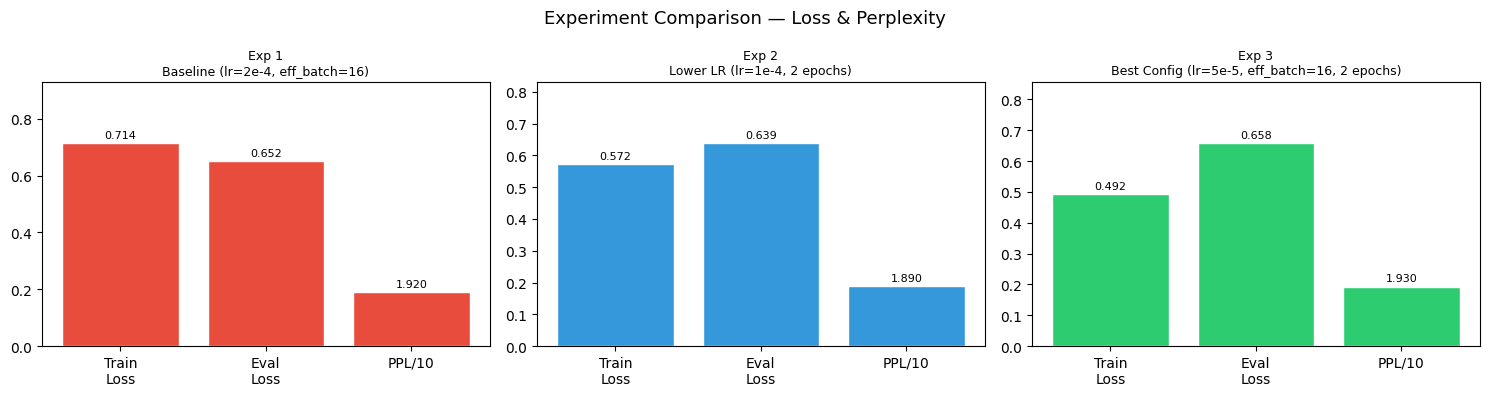


Best configuration: Lower LR (lr=1e-4, 2 epochs)
   Eval Loss  : 0.6386
   Perplexity : 1.89


In [ ]:
exp_df = pd.DataFrame(experiments)
print("\nHyperparameter Experiment Summary")
print("="*85)
print(exp_df.to_string(index=False))
print("="*85)

# Plot training losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ["#E74C3C", "#3498DB", "#2ECC71"]

for ax, (_, row), color in zip(axes, exp_df.iterrows(), colors):
    metrics = ["Train Loss", "Eval Loss", "Perplexity"]
    values  = [row["Train Loss"], row["Eval Loss"], row["Perplexity"] / 10]  # scale perplexity
    bars = ax.bar(["Train\nLoss", "Eval\nLoss", "PPL/10"], values, color=color, edgecolor="white")
    ax.set_title(f"{row['Experiment']}\n{row['Label']}", fontsize=9)
    ax.set_ylim(0, max(values) * 1.3)
    for bar, val in zip(bars, [row["Train Loss"], row["Eval Loss"], row["Perplexity"]]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f"{val:.3f}", ha="center", va="bottom", fontsize=8)

plt.suptitle("Experiment Comparison — Loss & Perplexity", fontsize=13)
plt.tight_layout()
plt.savefig("experiment_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

# Identify best experiment
best_exp = exp_df.loc[exp_df["Eval Loss"].idxmin()]
print(f"\nBest configuration: {best_exp['Label']}")
print(f"   Eval Loss  : {best_exp['Eval Loss']}")
print(f"   Perplexity : {best_exp['Perplexity']}")

## Cell 9 — ROUGE & BLEU Evaluation (Base vs Fine-Tuned)
We compare **base TinyLlama** vs our **fine-tuned model** on 100 held-out examples.

Loading base model pipeline for comparison...

Loading fine-tuned model (Exp 2) pipeline...


The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyFo


Evaluating on 100 validation examples...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   20/100 done...
   40/100 done...
   60/100 done...
   80/100 done...
   100/100 done...
Generation complete.

Base vs Fine-Tuned Evaluation Metrics
 Metric  Base Model  Fine-tuned  Improvement   Δ %
ROUGE-1       32.11       25.51        -6.60 -20.6
ROUGE-2       20.11       15.71        -4.40 -21.9
ROUGE-L       27.06       21.50        -5.56 -20.5
   BLEU       10.24        9.11        -1.13 -11.0


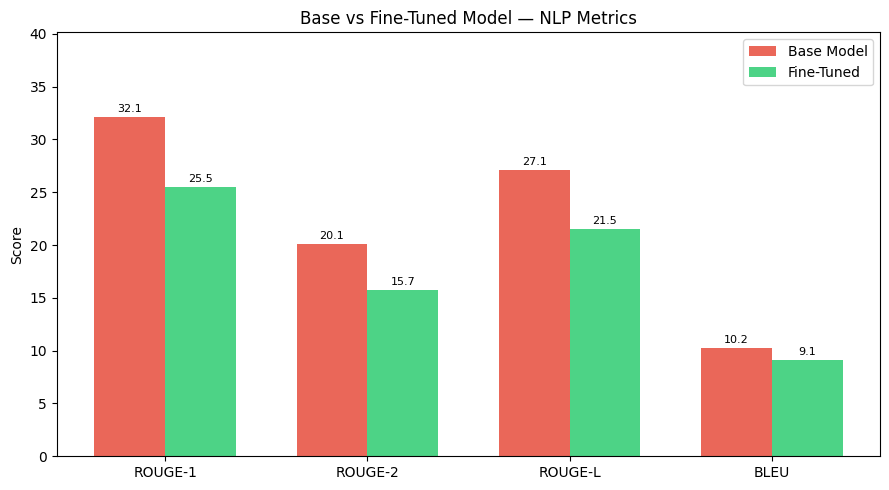

In [ ]:
rouge_metric = evaluate.load("rouge")
bleu_metric  = evaluate.load("sacrebleu")

# ── Helper: generate answer from a model pipeline ─────────────────────────────
def generate_answer(pipe, question: str, max_new_tokens: int = 150) -> str:
    prompt = (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{question}</s>\n"
        f"<|assistant|>\n"
    )
    result = pipe(prompt, max_new_tokens=max_new_tokens, do_sample=False, temperature=1.0)
    generated = result[0]["generated_text"]
    # Extract only the assistant reply
    if "<|assistant|>" in generated:
        reply = generated.split("<|assistant|>")[-1].strip()
        # Remove trailing special tokens
        for tok in ["</s>", "<|user|>", "<|system|>"]:
            reply = reply.split(tok)[0].strip()
        return reply
    return generated.strip()


# ── Load base model pipeline (frozen, no LoRA) ────────────────────────────────
print("Loading base model pipeline for comparison...")
base_pipe = pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
    max_new_tokens=150,
)

# ── Load best fine-tuned model pipeline ───────────────────────────────────────
best_exp_id = int(exp_df.loc[exp_df["Eval Loss"].idxmin()]["Experiment"].split()[-1])
adapter_path = f"./results/exp{best_exp_id}/adapter"

print(f"\nLoading fine-tuned model (Exp {best_exp_id}) pipeline...")
ft_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
ft_model = PeftModel.from_pretrained(ft_model, adapter_path)
ft_model.eval()

ft_pipe = pipeline(
    "text-generation",
    model=ft_model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
    max_new_tokens=150,
)

# ── Evaluate on 100 validation samples ────────────────────────────────────────
EVAL_SAMPLES = 100
eval_examples = val_split.select(range(min(EVAL_SAMPLES, len(val_split))))

base_preds, ft_preds, references = [], [], []

print(f"\nEvaluating on {len(eval_examples)} validation examples...")
for i, ex in enumerate(eval_examples):
    question  = ex["input"].strip()
    reference = ex["output"].strip()

    base_ans = generate_answer(base_pipe, question)
    ft_ans   = generate_answer(ft_pipe,  question)

    base_preds.append(base_ans)
    ft_preds.append(ft_ans)
    references.append(reference)

    if (i + 1) % 20 == 0:
        print(f"   {i+1}/{len(eval_examples)} done...")

print("Generation complete.")

# ── Compute ROUGE ──────────────────────────────────────────────────────────────
base_rouge = rouge_metric.compute(predictions=base_preds, references=references)
ft_rouge   = rouge_metric.compute(predictions=ft_preds,   references=references)

# ── Compute BLEU ───────────────────────────────────────────────────────────────
base_bleu = bleu_metric.compute(
    predictions=base_preds,
    references=[[r] for r in references]
)["score"]
ft_bleu = bleu_metric.compute(
    predictions=ft_preds,
    references=[[r] for r in references]
)["score"]

# ── Display results table ──────────────────────────────────────────────────────
metrics_df = pd.DataFrame({
    "Metric":      ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU"],
    "Base Model":  [
        round(base_rouge["rouge1"] * 100, 2),
        round(base_rouge["rouge2"] * 100, 2),
        round(base_rouge["rougeL"] * 100, 2),
        round(base_bleu, 2),
    ],
    "Fine-tuned":  [
        round(ft_rouge["rouge1"] * 100, 2),
        round(ft_rouge["rouge2"] * 100, 2),
        round(ft_rouge["rougeL"] * 100, 2),
        round(ft_bleu, 2),
    ],
})
metrics_df["Improvement"] = metrics_df["Fine-tuned"] - metrics_df["Base Model"]
metrics_df["Δ %"] = (metrics_df["Improvement"] / metrics_df["Base Model"] * 100).round(1)

print("\nBase vs Fine-Tuned Evaluation Metrics")
print("="*60)
print(metrics_df.to_string(index=False))
print("="*60)

# Plot
fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(metrics_df))
w = 0.35
bars1 = ax.bar(x - w/2, metrics_df["Base Model"], w, label="Base Model",  color="#E74C3C", alpha=0.85)
bars2 = ax.bar(x + w/2, metrics_df["Fine-tuned"],  w, label="Fine-Tuned", color="#2ECC71", alpha=0.85)
ax.set_xticks(x)
ax.set_xticklabels(metrics_df["Metric"])
ax.set_ylabel("Score")
ax.set_title("Base vs Fine-Tuned Model — NLP Metrics")
ax.legend()
ax.set_ylim(0, max(metrics_df["Fine-tuned"].max(), metrics_df["Base Model"].max()) * 1.25)
for bar in bars1:
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.3,
            f"{bar.get_height():.1f}", ha="center", va="bottom", fontsize=8)
for bar in bars2:
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.3,
            f"{bar.get_height():.1f}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.savefig("base_vs_finetuned_metrics.png", dpi=150, bbox_inches="tight")
plt.show()

## Cell 10 — Qualitative Comparison (Base vs Fine-Tuned)

In [ ]:
# Hand-picked questions for qualitative testing
qualitative_qs = [
    "What are the classic symptoms of appendicitis?",
    "How does metformin work in treating type 2 diabetes?",
    "What is the mechanism of action of beta-blockers?",
    "What is the difference between Type 1 and Type 2 diabetes?",
    "Explain the pathophysiology of myocardial infarction.",
    # Out-of-domain test (model should handle gracefully)
    "What is the best recipe for chocolate cake?",
]

print("Qualitative Comparison — Base vs Fine-Tuned Model\n")
print("="*70)

qualitative_results = []
for q in qualitative_qs:
    base_ans = generate_answer(base_pipe, q)
    ft_ans   = generate_answer(ft_pipe,  q)
    qualitative_results.append({"question": q, "base": base_ans, "finetuned": ft_ans})

    print(f"\nQUESTION: {q}")
    print(f"\n  [BASE MODEL]:\n  {base_ans[:300]}")
    print(f"\n  [FINE-TUNED]:\n  {ft_ans[:300]}")
    print("-"*70)

# Save qualitative results
with open("qualitative_results.json", "w") as f:
    json.dump(qualitative_results, f, indent=2)
print("\nQualitative results saved to qualitative_results.json")

Qualitative Comparison — Base vs Fine-Tuned Model


QUESTION: What are the classic symptoms of appendicitis?

  [BASE MODEL]:
  The classic symptoms of appendicitis include:

1. Pain in the right upper quadrant of the abdomen, usually in the right upper quadrant of the abdomen, but it can also occur in the left upper quadrant.

2. Nausea or vomiting.

3. Abdominal pain that is sharp, stabbing, or cramping.

4. Feeling of ful

  [FINE-TUNED]:
  The classic symptoms of appendicitis include fever, abdominal pain, and vomiting. These symptoms are indicative of an infection of the appendix, which is a small, fleshy organ that lies outside the large intestine. If left untreated, appendicitis can lead to severe complications, including perforati
----------------------------------------------------------------------

QUESTION: How does metformin work in treating type 2 diabetes?

  [BASE MODEL]:
  Metformin is a medication that works by reducing the production of insulin in the body. Insulin i

## Cell 11 — Gradio Web Interface
Launch an interactive chatbot UI to demo the fine-tuned medical assistant.

In [ ]:
import gradio as gr

# ── Chat state management ──────────────────────────────────────────────────────
# We keep a simple conversation history to allow multi-turn dialogue.

def chat_with_model(
    user_message: str,
    history: list,
    max_tokens: int = 200,
    temperature: float = 0.7,
) -> tuple[str, list]:
    """
    Generate a response from the fine-tuned model.
    Maintains conversation context (last 3 turns).
    """
    if not user_message.strip():
        return "", history

    # Build the prompt with the last 3 turns of history for context
    context = ""
    for turn in history[-3:]:
        context += f"<|user|>\n{turn[0]}</s>\n<|assistant|>\n{turn[1]}</s>\n"

    prompt = (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"{context}"
        f"<|user|>\n{user_message.strip()}</s>\n"
        f"<|assistant|>\n"
    )

    result = ft_pipe(
        prompt,
        max_new_tokens=max_tokens,
        do_sample=temperature > 0,
        temperature=max(temperature, 0.01),
        top_p=0.9,
        repetition_penalty=1.1,
    )
    generated = result[0]["generated_text"]

    # Extract reply
    reply = generated.split("<|assistant|>")[-1].strip()
    for tok in ["</s>", "<|user|>", "<|system|>"]:
        reply = reply.split(tok)[0].strip()

    if not reply:
        reply = "I'm sorry, I wasn't able to generate a response. Please rephrase your question."

    history.append((user_message, reply))
    return "", history


# ── Gradio UI Layout ───────────────────────────────────────────────────────────
css = """
#chatbot { height: 480px; overflow-y: auto; }
.gradio-container { max-width: 860px; margin: auto; }
h1 { text-align: center; color: #1a5276; }
.disclaimer { font-size: 12px; color: #888; text-align: center; margin-top: 4px; }
"""

example_questions = [
    "What are the symptoms of appendicitis?",
    "How does metformin work for diabetes?",
    "What is the mechanism of beta-blockers?",
    "Explain the pathophysiology of myocardial infarction.",
    "What are common side effects of ACE inhibitors?",
    "What is the difference between viral and bacterial pneumonia?",
    "How is sepsis diagnosed and treated?",
    "What is Cushing's syndrome caused by?",
]

with gr.Blocks(css=css, title="Medical Q&A Chatbot") as demo:
    gr.Markdown("# Medical Q&A Chatbot")
    gr.Markdown(
        "Fine-tuned **TinyLlama-1.1B** on medical flashcard data using **LoRA (QLoRA)**.  \n"
        "Ask any clinical or biomedical question below."
    )
    gr.Markdown(
        "Disclaimer: This chatbot is for **educational purposes only** and should not "
        "replace professional medical advice, diagnosis, or treatment.",
        elem_classes="disclaimer"
    )

    chatbot = gr.Chatbot(elem_id="chatbot", label="Conversation")
    state   = gr.State([])

    with gr.Row():
        user_input = gr.Textbox(
            placeholder="Ask a medical question...",
            label="Your Question",
            lines=2,
            scale=5,
        )
        submit_btn = gr.Button("Send", scale=1, variant="primary")

    with gr.Accordion("Generation Settings", open=False):
        max_tokens  = gr.Slider(50, 400, value=200, step=10, label="Max New Tokens")
        temperature = gr.Slider(0.1, 1.0, value=0.7, step=0.05, label="Temperature")

    clear_btn = gr.Button("Clear Conversation", variant="secondary")

    gr.Examples(
        examples=[[q] for q in example_questions],
        inputs=user_input,
        label="Example Questions (click to load)",
    )

    # Event wiring
    submit_btn.click(
        fn=chat_with_model,
        inputs=[user_input, state, max_tokens, temperature],
        outputs=[user_input, chatbot],
    )
    user_input.submit(
        fn=chat_with_model,
        inputs=[user_input, state, max_tokens, temperature],
        outputs=[user_input, chatbot],
    )
    clear_btn.click(lambda: ([], []), outputs=[chatbot, state])

# Launch with a public share link for Colab
print("Launching Gradio interface...")
demo.launch(share=True, debug=False)

Launching Gradio interface...
IMPORTANT: You are using gradio version 4.31.0, however version 4.44.1 is available, please upgrade.
--------
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cfa2c749031094b1bb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Cell 12 — Save & Export Final Model

In [ ]:
# Merge LoRA weights into base model and save in full precision
# (optional — requires enough CPU RAM; comment out if you hit OOM)

print("Saving final LoRA adapter...")
adapter_save_path = "./final_medical_chatbot_adapter"
ft_model.save_pretrained(adapter_save_path)
tokenizer.save_pretrained(adapter_save_path)
print(f"Adapter saved to: {adapter_save_path}")

# Save experiment table as CSV for the README
exp_df.to_csv("experiment_results.csv", index=False)
metrics_df.to_csv("evaluation_metrics.csv", index=False)
print("experiment_results.csv saved")
print("evaluation_metrics.csv saved")

print("\nPipeline complete! Files generated:")
print("   ├── final_medical_chatbot_adapter/   (LoRA weights)")
print("   ├── experiment_results.csv")
print("   ├── evaluation_metrics.csv")
print("   ├── qualitative_results.json")
print("   ├── dataset_distribution.png")
print("   ├── experiment_comparison.png")
print("   └── base_vs_finetuned_metrics.png")

Saving final LoRA adapter...
Adapter saved to: ./final_medical_chatbot_adapter
experiment_results.csv saved
evaluation_metrics.csv saved

Pipeline complete! Files generated:
   ├── final_medical_chatbot_adapter/   (LoRA weights)
   ├── experiment_results.csv
   ├── evaluation_metrics.csv
   ├── qualitative_results.json
   ├── dataset_distribution.png
   ├── experiment_comparison.png
   └── base_vs_finetuned_metrics.png
